In [1]:
import os
from collections import OrderedDict
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from torchvision import transforms
import os
from PIL import Image
from torch.utils import data
import numpy as np
from torchvision import transforms as T
import time
import torch as t
from torch import nn
from torch.nn import functional as F
import torchvision
###工具函数
import visdom
import time
import numpy as np
import torch
from torchvision import models
from torchnet import meter
import pandas as pd
from torch.autograd import Variable

In [2]:
root = "I:/data/dogcat/Demo/"

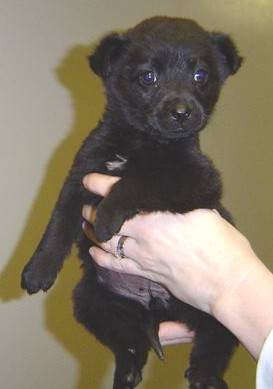

In [3]:
##数据可视化
cat1 = Image.open(os.path.join(root,'cat.200.jpg'))
dog1 = Image.open(os.path.join(root,'dog.200.jpg'))
dog1

# Data Loader

In [4]:
class DogCat(data.Dataset):
    '''
    Dataset，加载猫狗数据集
    '''
    def __init__(self,root,transforms=None,train=True,test=False):
        """
        目标：获取所有图片地址，并根据地址训练、验证、测试划分数据
        """
        self.test = test
        imgs = [os.path.join(root,img) for img in os.listdir(root)]
        
        ##test1: I:/data/dogcat/test/test/1.jpg
        ##train: I:/data/dogcat/train/train/cat.0.jpg
        if self.test:
            imgs = sorted(imgs, key=lambda x: int(x.split('.')[-2].split('/')[-1]))
            print("测试集的数目为：",len(imgs))
        else:
            imgs = sorted(imgs, key= lambda x:int(x.split('.')[-2]))
            print("训练集的数目为：",len(imgs))
        
        imgs_num = len(imgs)
        
        #划分训练集、验证集，训练验证7：3
        if self.test:
            self.imgs = imgs
        elif train:
            self.imgs = imgs[:int(0.7*imgs_num)]
        else:
            self.imgs = imgs[int(0.7*imgs_num):]
        
        if transforms is None:
            
            ##对数据进行转换，如果没有指定transform，这里设置一个默认的转换,对训练测试验证处理有所区别
            """normalize = T.Normalize(mean=[0.485,0.456,0.406],
                                   std = [0.229,0.224,0.225])###测试集验证集和训练集有所区别的原因是数据数目不同"""
            normalize = T.Normalize(mean=[0.48,0.48,0.48],
                                   std = [0.229,0.229,0.229])##先设置为一致的
            
            ##测试集和验证集
            if self.test or not train:
                self.transforms = T.Compose([
                    T.Resize(224),
                    T.CenterCrop(224),#图片不是统一大小，所以从中间裁剪出224的，这里会对分类效果有影响
                    T.ToTensor(),
                    normalize
                ])
            ##训练集
            else:
                self.transforms = T.Compose([
                    T.Resize(256),
                    T.RandomResizedCrop(224),###因为训练集要训练多个epoch  所以随机选取  不能直接裁成224，不然选的都一样了
                    T.RandomHorizontalFlip(),#数据增强
                    T.ToTensor(),
                    normalize
                ])
            
            
    def __getitem__(self,index):
        """
        返回一张图片的数据
        如果是测试集，没有图片id，如1000.jpg返回1000
        """
        img_pth = self.imgs[index]
        if self.test:
            label = int(self.imgs[index].split('.')[-2].split('/')[-1])
        else:
            label = 1 if 'dog' in img_pth.split('/')[-1] else 0 ###狗是1 猫是0
        data = Image.open(img_pth)
        data = self.transforms(data)
        return data,label

    def __len__(self):
        '''
        返回数据集中所有图片的个数
        '''
        return len(self.imgs)

# Model

In [5]:
class VggWithCustomLayers(nn.Module):

    def __init__(self, *args, **kwargs):
        super(VggWithCustomLayers, self).__init__(*args, **kwargs)
        self.vgg = torchvision.models.vgg19_bn(pretrained=True,progress=True)
        for param in self.vgg.parameters():
            param.requires_grad = False
        in_features = self.vgg.classifier[-1].in_features
        block = torch.nn.Sequential(OrderedDict([
            ("conv_1", torch.nn.Linear(in_features, 2)),
            ("softmax", torch.nn.Sigmoid())
        ]))
        self.vgg.classifier[-1] = block

    def forward(self, x):
        x = self.vgg(x)
        return x


In [6]:
class Resnet34(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Resnet34, self).__init__(*args, **kwargs)
        self.res = torchvision.models.resnet34(pretrained=True)
        for param in self.res.parameters():
            param.requires_grad = False

        self.res.fc = nn.Linear(512,2)
    def forward(self, x):
        x = self.res(x)
        return x

# Visualizer

In [7]:
class Visualizer(object):
    '''
    封装了visdom的基本操作，但仍然可以通过self.vis.function 或者self.function 来调用原有的visdom接口
    '''
    """
    例如self.text('hello visdom')
    self.histogram(t.randn(1000))
    self.line(t.arange(0,10),t.arange(1,11))
    """
    def __init__(self,env='default',**kwargs):
        self.vis = visdom.Visdom(env = env,**kwargs)
        ##保存('loss'，23)即loss的第23个点
        self.index = {}
        self.log_text = ''
    
    def reinit(self,env='default',**kwargs):
        '''
        修改visdom的配置
        '''
        self.vis = visdom.Visdom(env=env,**kwargs)
        return self
    
    def plot_many(self,d):
        '''
        一次plot多个
        @params d:dict(name,value) i.e. ('loss',0.11)
        '''
        for k,v in d.items():
            self.plot(k,v)
    
    def img_many(self,d):
        for k,v in d.items():
            self.img(k,v)
    
    def plot(self,name,y,**kwargs):
        '''
        self.plot('loss',1.00)
        '''
        x = self.index.get(name,0)
        self.vis.line(Y=np.array([y]),X=np.array([x]),
                     win=(name),opts=dict(title=name),update=None if x==0 else 'append',**kwargs)
        self.index[name] = x+1
    
    def img(self,name,img_,**kwargs):
        '''
        self.img('input_img',t.Tensor(64,64))
        '''
        self.vis.images(img_.cpu().numpy(),
                       win=(name),
                       opts = dict(title=name),
                       **kwargs)
    
    def log(self,info,win = 'log_text'):
        '''
        self.log({'loss':1,"lr":0.0001})
        '''
        self.log_text += ('[{time}] {info} <br>'.format(time=time.strftime('%%d_%H%M%S'),
                                                       info=info))
        self.vis.text(self.log_text,win)
    
    def __getattr__(self,name):
        '''
        自定义的plot,image,log,plot_many等除外
        self.functiom 等价于self.vis.function
        '''
        return getattr(self.vis,name)

# Config

In [8]:
class DefaultConfig(object):
    env = 'default'  ##vidom的环境
    model = None  #使用的模型
    
    train_data_root = root
    load_model_path = None#"I:/torch/models/alexnet.pth"  ##加载预训练模型的路径 为None就不加载
    
    batch_size= 8
    use_gpu=True ##
    num_workers = 0
    print_freq = 20  ###每间隔多少个batch打印一次信息
    
    max_epoch = 10
    lr = 0.1 ##初始化的学习率
    lr_decay = 0.95  #学习率衰减率，等 损失增加的时候，衰减学习率 lr = lr*0.95
    weight_decay = 1e-4  ##损失函数
    
    def parse(self,kwargs):
        '''
        根据字典更新config参数
        '''
        ##更新配置参数
        for k,v in kwargs.items():
            if not hasattr(self,k):
                warnings.warn("Warning: opt has not attribute %s" %k)
            setattr(self,k,v)
        ##打印配置信息
        for k,v in self.__class__.__dict__.items():
            if not k.startswith('__'):
                print(k,getattr(self,k))

# Train & Validation

In [9]:
def train(**kwargs):
    
    ##根据命令行参数更新配置
    opt.parse(kwargs)
    vis = Visualizer(opt.env)
    
    ##step1:模型
    #model = VggWithCustomLayers()
    model = Resnet34()

    if opt.load_model_path:
        model.load(opt.load_model_path)
    if hasattr(t.cuda,'empty_cache'):
        t.cuda.empty_cache()
    if opt.use_gpu: model.cuda()
    
    #step2: 数据
    train_data = DogCat(opt.train_data_root,train=True)
    val_data = DogCat(opt.train_data_root,train=False)
    train_dataloader = DataLoader(train_data,opt.batch_size,
                                 shuffle=True,
                                 num_workers = opt.num_workers)
    val_dataloader = DataLoader(val_data,opt.batch_size,
                               shuffle=True,
                               num_workers=opt.num_workers)
    
    ##step3:目标函数和优化器
    criterion = t.nn.CrossEntropyLoss()
    lr = opt.lr
    optimizer = t.optim.Adam(model.parameters(),
                            lr = lr,
                            weight_decay = opt.weight_decay)
    ##step4:统计指标:平滑处理后的损失，还又混淆矩阵
    loss_meter = meter.AverageValueMeter()
    confusion_matrix = meter.ConfusionMeter(2)
    previous_loss = 1e100
    loss_train_epo = meter.AverageValueMeter()
    train_loss= []
    val_loss = []
    ##训练
    for epoch in range(opt.max_epoch):
        loss_meter.reset()
        confusion_matrix.reset()
        
        for ii,(data,label) in enumerate(train_dataloader):
            ###训练模型参数
            inputt = Variable(data)
            target = Variable(label)
            if opt.use_gpu:
                inputt = inputt.cuda()
                target = target.cuda()
            optimizer.zero_grad()
            if hasattr(torch.cuda,'empty_cache'):
                torch.cuda.empty_cache()
            score = model(inputt)
            loss = criterion(score,target)
            loss.backward()
            optimizer.step()
            
            ##更新统计指标以及可视化
            loss_meter.add(loss.item())
            confusion_matrix.add(score.data,target.data)
            loss_train_epo.add(loss.item())
            if ii%opt.print_freq == opt.print_freq-1:
                vis.plot('loss',loss_meter.value()[0])
                
        #vis.plot('epo_loss',loss_train_epo.value()[0])
        train_loss.append(loss_train_epo.value()[0])
        cm = confusion_matrix.value()
        train_accuracy = 100. * (cm[0][0]+cm[1][1]) /(cm.sum())
        ##计算验证集上的指标以及可视化
        val_cm,val_accuracy,loss_val = val(model,val_dataloader)
        #vis.plot('eop_loss',loss_val.value()[0])
        val_loss.append(loss_val.value()[0])
        vis.plot('train_accuracy',train_accuracy)
        vis.plot('val_accuracy',val_accuracy)
        vis.log("epoch:{epoch},lr:{lr},loss:{loss},train_cm:{train_cm},val_cm:{val_cm},val_accuray:{val_accuracy}"
               .format(
               epoch=epoch,
                loss = loss_meter.value()[0],
                val_cm =str(val_cm.value()),
                train_cm = str(confusion_matrix.value()),
                lr = lr,
                val_accuracy = val_accuracy
               ))

        #如果损失不下降，则降低学习率
        if loss_meter.value()[0]>previous_loss:
            lr = lr*opt.lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        previous_loss = loss_meter.value()[0]
    loss = (train_loss
           ,val_loss)
    name = ['Train','Val']
    vis.line(
    Y=np.column_stack((loss[0],loss[1])),
    X=np.column_stack(([i for i in range(1,opt.max_epoch+1)],[i for i in range(1,opt.max_epoch+1)])),
    opts=dict(markers=False, legend=name,win='epoch_loss',title="epoch_loss",xlabel='epoch',ylabel='loss'))
    return loss

In [10]:
def val(model,dataloader):
    '''
    计算模型在验证集上的准确率等信息
    '''
    ##把模型设置为验证模式
    model.eval()#把模型model.eval()作用是为了固定BN和dropout层，使得偏置参数不随着发生变化。因为当batchsize小时，如果没有固定，会对图像的失真有很大的影响。
    #不启用 BatchNormalization 和 Dropout，保证BN和dropout不发生变化，pytorch框架会自动把BN和Dropout固定住，不会取平均，而是用训练好的值，不然的话，一旦test的batch_size过小，很容易就会被BN层影响结果。
    confusion_matrix = meter.ConfusionMeter(2)
    loss_meter = meter.AverageValueMeter() 
    criterion = t.nn.CrossEntropyLoss()

    for ii,data in enumerate(dataloader):
        inputt,label = data
        val_input = Variable(inputt,volatile=True)
        val_label = Variable(label.long(),volatile=True)#volatile 不会求导
        if opt.use_gpu:
            val_input = val_input.cuda()
            val_label = val_label.cuda()
        score = model(val_input)
        val_loss = criterion(score,val_label)
        confusion_matrix.add(score.data.squeeze(),label.long())
        loss_meter.add(val_loss.item())

                
    ##把模型恢复为训练模式
    model.train()
    
    cm_value = confusion_matrix.value()
    accuracy = 100. * (cm_value[0][0]+cm_value[1][1]) /(cm_value.sum())
    return confusion_matrix,accuracy,loss_meter

# Main

## VGG

In [11]:
opt = DefaultConfig()
new_config = {'lr':0.01,'use_gpu':True,'max_epoch':5,'batch_size':16,'env':'vgg','print_freq':5,'model':VggWithCustomLayers()}
opt.parse(new_config)
train()

Setting up a new session...


env vgg
model VggWithCustomLayers(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, s

训练集的数目为： 1835
训练集的数目为： 1835


D:\anaconda\envs\forPytorch\lib\site-packages\ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
D:\anaconda\envs\forPytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


([0.27254548195151623,
  0.34609135892529624,
  0.3274262823440409,
  0.3405437600084513,
  0.3418043942972198],
 [0.04141530080731692,
  0.21385662620388238,
  0.243854391495032,
  0.05243232428978705,
  0.11990515227163474])

## ResNet

In [14]:
opt = DefaultConfig()
new_config = {'lr':0.01,'use_gpu':True,'max_epoch':5,'batch_size':16,'env':'Res','print_freq':5,'model':Resnet34()}
opt.parse(new_config)
loss = train()


Setting up a new session...


env Res
model Resnet34(
  (res): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

训练集的数目为： 1835
训练集的数目为： 1835


D:\anaconda\envs\forPytorch\lib\site-packages\ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
D:\anaconda\envs\forPytorch\lib\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


In [15]:
name = ['Train','Val']
vis.line(
Y=np.column_stack((loss[0],loss[1])),
X=np.column_stack(([i for i in range(1,opt.max_epoch+1)],[i for i in range(1,opt.max_epoch+1)])),
opts=dict(markers=False, legend=name,win='epoch_loss',title="epoch_loss",xlabel='epoch',ylabel='loss'))

NameError: name 'vis' is not defined